In [1]:
# Import all the necessary libraries.
import numpy as np
import timeit
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [2]:
# Reset pseudo random generator to a known value so that results are reproducible.
seed = 42
np.random.seed(seed)

In [3]:
def true_func(N):
    include_bias = True
    x = np.sort(6*np.random.rand(N) - 3).reshape(N, 1)
    # Second order polynomial.
    y = 0.5*x**2 + x + 2
    # Noise.
    w = np.random.randn(N, 1)
    y_noisy = y + w
    # Polinomial degrees to be tested.
    degrees = [1, 2, 20]    
    return x, y, y_noisy, include_bias, degrees

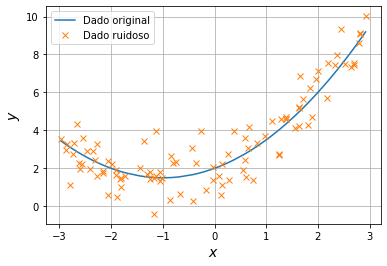

In [4]:
# Example set size.
N = 100

# Generate the dataset.
x, y, y_noisy, include_bias, degrees = true_func(N)

# Plot original data versus noisy version.
fig = plt.figure()
plt.plot(x, y, label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
# Save figure
#plt.savefig("noisy_function.png", dpi=600)

#Show the plot.
plt.show()

In [5]:
testSize = [0.1, 0.2, 0.3, 0.4]

numOfSeeds = 100

mse_training = np.zeros((len(testSize), len(degrees), int(N*(1.0 - 0.1))+1 ))
mse_validation = np.zeros((len(testSize), len(degrees), int(N*(1.0 - 0.1))+1 ))

for t in range(0, len(testSize)):
    
    # Number of training samples.
    trainSize = int(N*(1.0 - testSize[t]))

    # Iterate over the degrees.
    for i in range(0, len(degrees)):
        
        # Instantiate a polynomial.
        poly = PolynomialFeatures(degree=degrees[i], include_bias=include_bias)
        # Instantiate a scaler.
        scaler = StandardScaler()
        # Instantiate a linear regressor.
        reg = LinearRegression()

        # Create a pipeline of actions.
        poly_reg = Pipeline([
            ("poly", poly),
            ("scaler", scaler),
            ("reg", reg),
        ])
        
        # Iterate over the size of the training set.
        for m in range(1, trainSize+1):                
                
            # Use several different seeds.
            for s in range(0, numOfSeeds):     

                # Split the whole set into random training and validation set.
                x_train, x_val, y_train, y_val = train_test_split(x, y_noisy, test_size=testSize[t], random_state=s)

                # Perform polynomial regression.
                poly_reg.fit(x_train[:m], y_train[:m])

                # Use the trained model for prediction of the training set.
                y_train_predict = poly_reg.predict(x_train[:m])

                # Use the trained model for prediction of the validation set.
                y_val_predict = poly_reg.predict(x_val)       

                # Calculate SE for training set.
                mse_training[t][i][m-1] += mean_squared_error(y_train[:m], y_train_predict)

                # Calculate SE for validation set.
                mse_validation[t][i][m-1] += mean_squared_error(y_val, y_val_predict)
            
            mse_training[t][i][m-1] /= numOfSeeds
            mse_validation[t][i][m-1] /= numOfSeeds

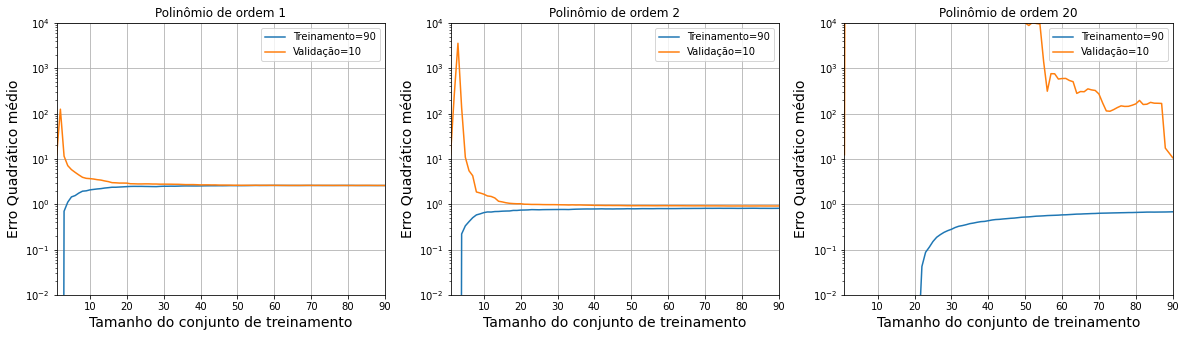

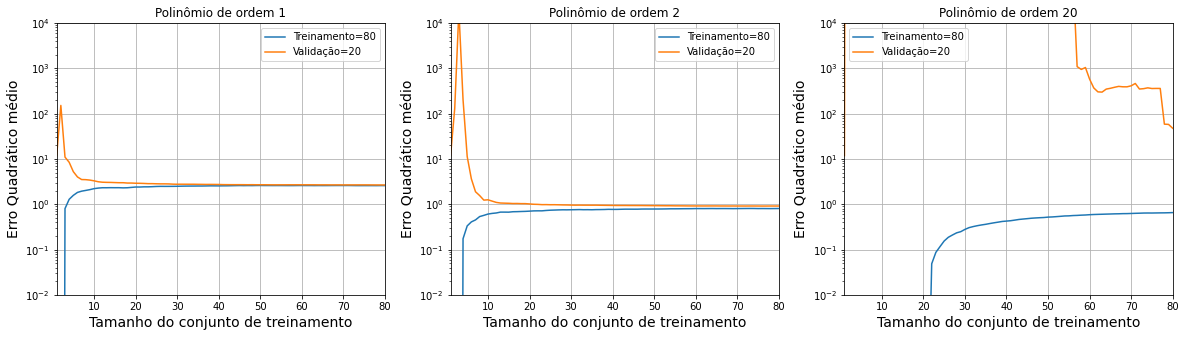

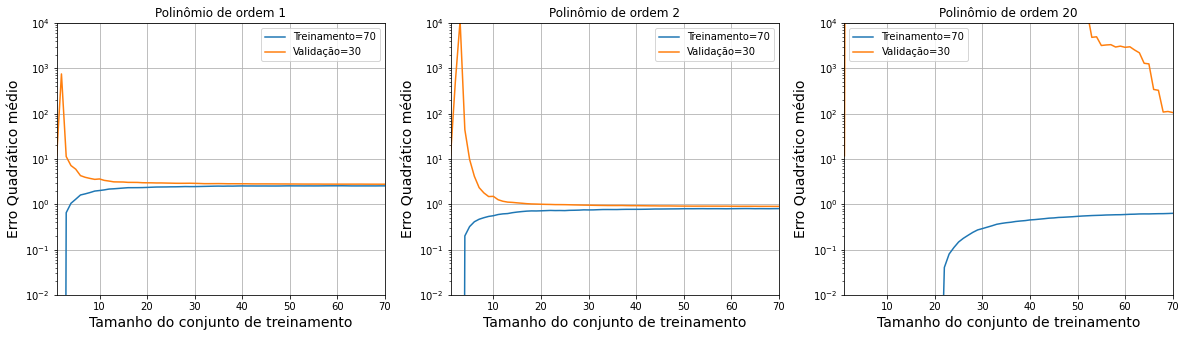

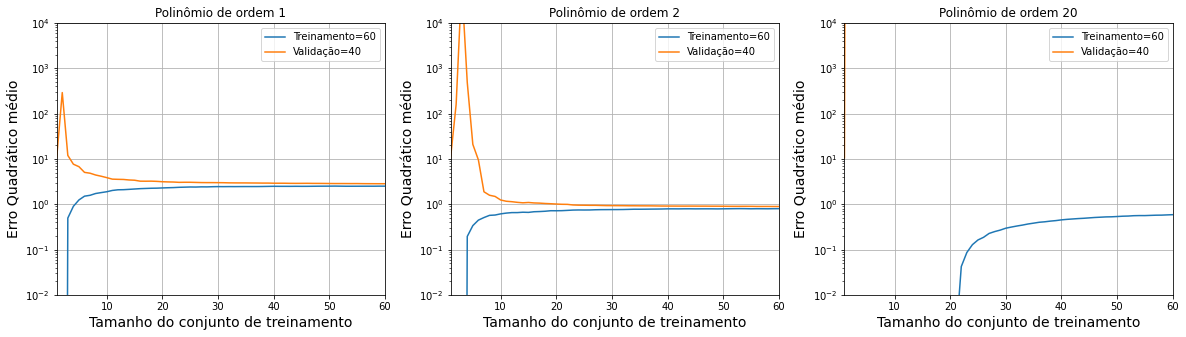

In [6]:
for t in range(0,len(testSize)):
    
    plt.figure(figsize=(20, 5))
    
    trainSize = int(N*(1.0 - testSize[t]))
    
    for i in range(0, len(degrees)):
        
        ax = plt.subplot(1, len(degrees), i + 1)
    
        plt.plot(range(1, trainSize+1), mse_training[t][i][0:trainSize], label='Treinamento='+str(trainSize))
        plt.plot(range(1, trainSize+1), mse_validation[t][i][0:trainSize], label='Validação='+str(N-trainSize))
        plt.yscale('log')
        plt.xlabel('Tamanho do conjunto de treinamento', fontsize=14)
        plt.ylabel('Erro Quadrático médio', fontsize=14)
        plt.grid()
        plt.ylim([1e-2, 1e4])
        plt.xlim([1, trainSize])
        plt.title('Polinômio de ordem '+str(degrees[i]))
        plt.legend(loc='best')
    
    # Show the plot.
    plt.show()